# **Diabetes Technical Case**
<br>
<br>


#### Creating the connection with drive repo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Insatalling necessary libs

In [ ]:
# !pip install category_encoders --quiet
# !pip install skfeature-chappers --quiet
# !pip install xgboost --quiet
# !pip install autokeras --quiet
# !pip install pycaret[full] --quiet
# !pip install scikit-learn --quiet
# !pip install shap --quiet

#### Import of Libs

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#import autokeras as ak
#import tensorflow as tf
from pycaret.classification import *

import shap
shap.initjs()

### Inicial Importing & Treatment of the Dataset

In [ ]:
pd.set_option('display.max_columns', None) # To show all the columns

df = pd.read_csv('/content/diabetic_data.csv')

# Replacing the "?" string to understand better the NA's in the Dataset
df.replace('?', np.nan, inplace=True)

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Removing Scientific Notation

df.describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.99]).drop(columns=['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00
mean,4.40,43.10,1.34,16.02,0.37,0.20,0.64,7.42
std,2.99,19.67,1.71,8.13,1.27,0.93,1.26,1.93
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00
10%,1.00,14.00,0.00,7.00,0.00,0.00,0.00,5.00
25%,2.00,31.00,0.00,10.00,0.00,0.00,0.00,6.00
50%,4.00,44.00,1.00,15.00,0.00,0.00,0.00,8.00
75%,6.00,57.00,2.00,20.00,0.00,0.00,1.00,9.00
90%,9.00,67.00,4.00,26.00,1.00,1.00,2.00,9.00
99%,14.00,85.00,6.00,43.00,5.00,3.00,6.00,9.00


#### Treating the null values properly

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

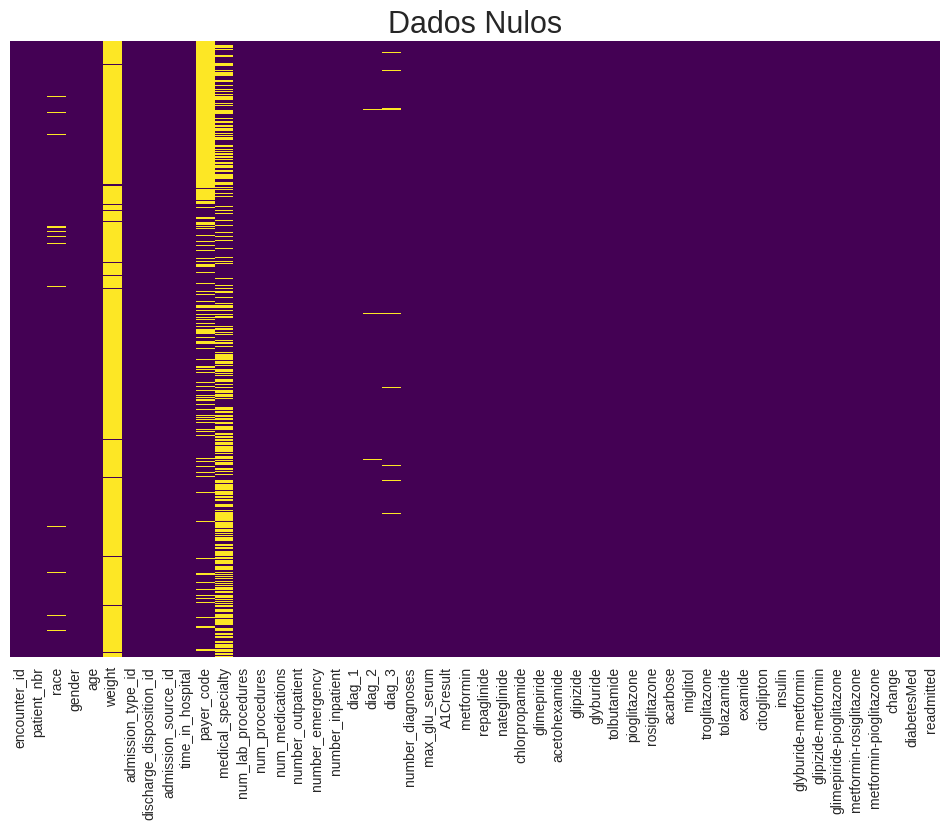

In [ ]:
print(pd.isnull(df).sum())

plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Dados Nulos',size = 22)
plt.show()

In [ ]:
df.shape # Shape before dealing with NA's

(101766, 50)

In [ ]:
df.drop(columns=['weight', 'medical_specialty', 'payer_code'], inplace=True) # dropping those columns, because they are full of NA's

In [ ]:
# Function to check if the column values are string or numeric
def is_numeric(col):
    return pd.to_numeric(col, errors='coerce').notna().all()

# Loop through each column to determine its type and replace NaNs accordingly
for column in df.columns:
    if is_numeric(df[column]):
        # Numeric column, replace NaNs with the mean
        df[column].fillna(df[column].mean(), inplace=True)
    else:
        # String column, replace NaNs with the mode
        df[column].fillna(df[column].mode()[0], inplace=True)

df.shape

(101766, 47)

In [ ]:
print(f"Amount of nulls left in the dataframe after treatment: {sum(pd.isnull(df.columns))}")

Amount of nulls left in the dataframe after treatment: 0


<br>

## **Exploratory Data Analysis**
<br>

### Descriptive Analysis



<br>

##### Understanding the Distribution of some columns with value counts

In [ ]:
a = df['race'].value_counts(dropna=False)
b = df['race'].value_counts(dropna=False,normalize=True)*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
Caucasian,78372,77.01
AfricanAmerican,19210,18.88
Hispanic,2037,2.00
Other,1506,1.48
Asian,641,0.63


In [ ]:
df = df[df['gender'] != 'Unknown/Invalid'] # There is 1 value of 'Unknown/Invalid' that now is already removed

a = df['gender'].value_counts()
b = df['gender'].value_counts(normalize=True)*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
Female,54708,53.76
Male,47055,46.24


In [ ]:
a = df['age'].value_counts()
b = df['age'].value_counts(normalize=True)*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
[70-80),26066,25.61
[60-70),22482,22.09
[50-60),17256,16.96
[80-90),17197,16.90
[40-50),9685,9.52
[30-40),3775,3.71
[90-100),2793,2.74
[20-30),1657,1.63
[10-20),691,0.68
[0-10),161,0.16


In [ ]:
a = df['time_in_hospital'].value_counts() # days in hospital
b = df['time_in_hospital'].value_counts(normalize=True)*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
3,17756,17.45
2,17224,16.93
1,14206,13.96
4,13924,13.68
5,9966,9.79
6,7539,7.41
7,5859,5.76
8,4390,4.31
9,3002,2.95
10,2342,2.30


In [ ]:
a = df['num_procedures'].value_counts()
b = df['num_procedures'].value_counts(normalize=True)*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
0,46652,45.84
1,20741,20.38
2,12716,12.50
3,9443,9.28
6,4954,4.87
4,4180,4.11
5,3077,3.02


In [ ]:
a = df['num_medications'].value_counts()[0:8]
b = (df['num_medications'].value_counts(normalize=True)[0:8])*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
13,6086,5.98
12,6004,5.90
11,5795,5.69
15,5792,5.69
14,5707,5.61
16,5430,5.34
10,5346,5.25
17,4919,4.83


In [ ]:
a = df['change'].value_counts()
b = df['change'].value_counts(normalize=True)*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
No,54754,53.81
Ch,47009,46.19


In [ ]:
a = df['diabetesMed'].value_counts()[0:8]
b = (df['diabetesMed'].value_counts(normalize=True)[0:8])*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
Yes,78361,77.00
No,23402,23.00


In [ ]:
a = df['readmitted'].value_counts()[0:8]
b = (df['readmitted'].value_counts(normalize=True)[0:8])*100

pd.concat([a,b], axis=1, keys=['Value_counts', 'Percentual (%)'])

,Value_counts,Percentual (%)
NO,54861,53.91
>30,35545,34.93
<30,11357,11.16


<br>

#### Now seing some of them on histograms/countplots

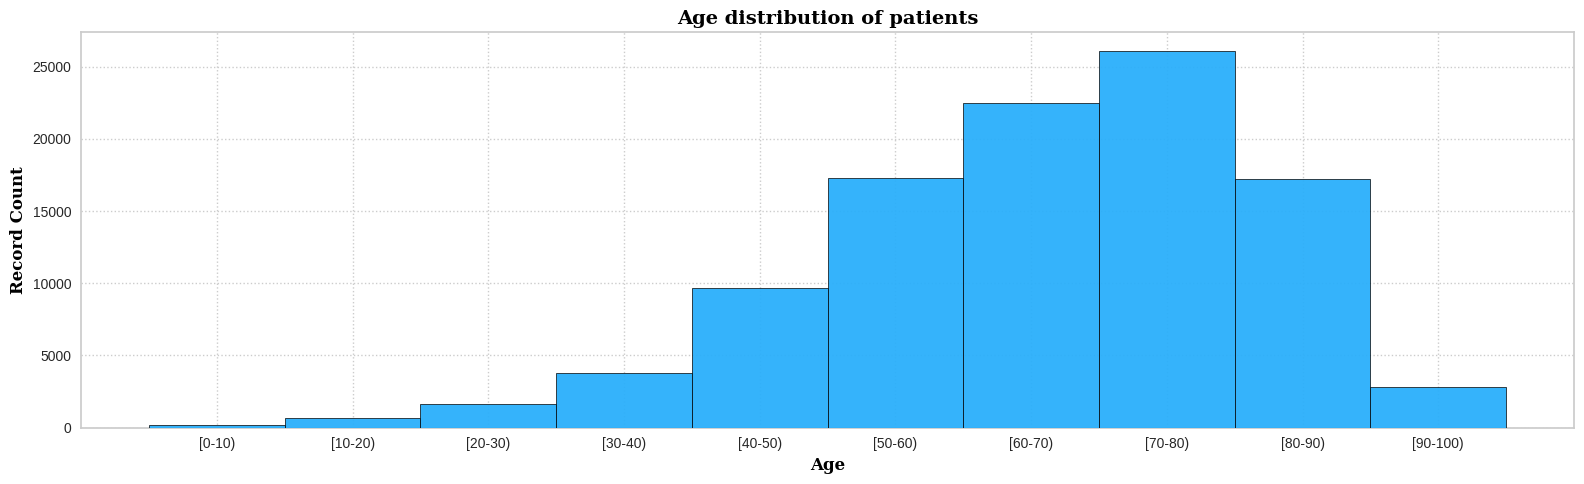

In [ ]:
plt.figure(figsize = (16,5))
sns.histplot(x = 'age',data = df, color = '#2aaffb', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Age', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Age distribution of patients', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.tight_layout()

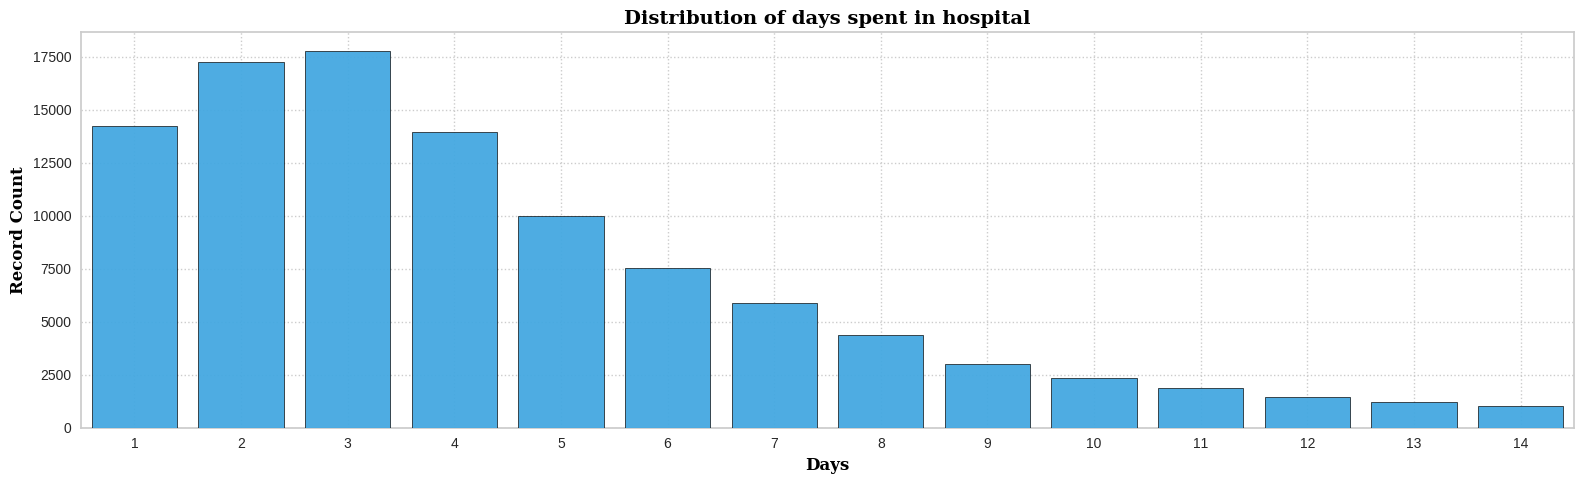

In [ ]:
plt.figure(figsize = (16,5))
sns.countplot(x = 'time_in_hospital',data = df, color = '#2aaffb', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Days', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Distribution of days spent in hospital', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.tight_layout()

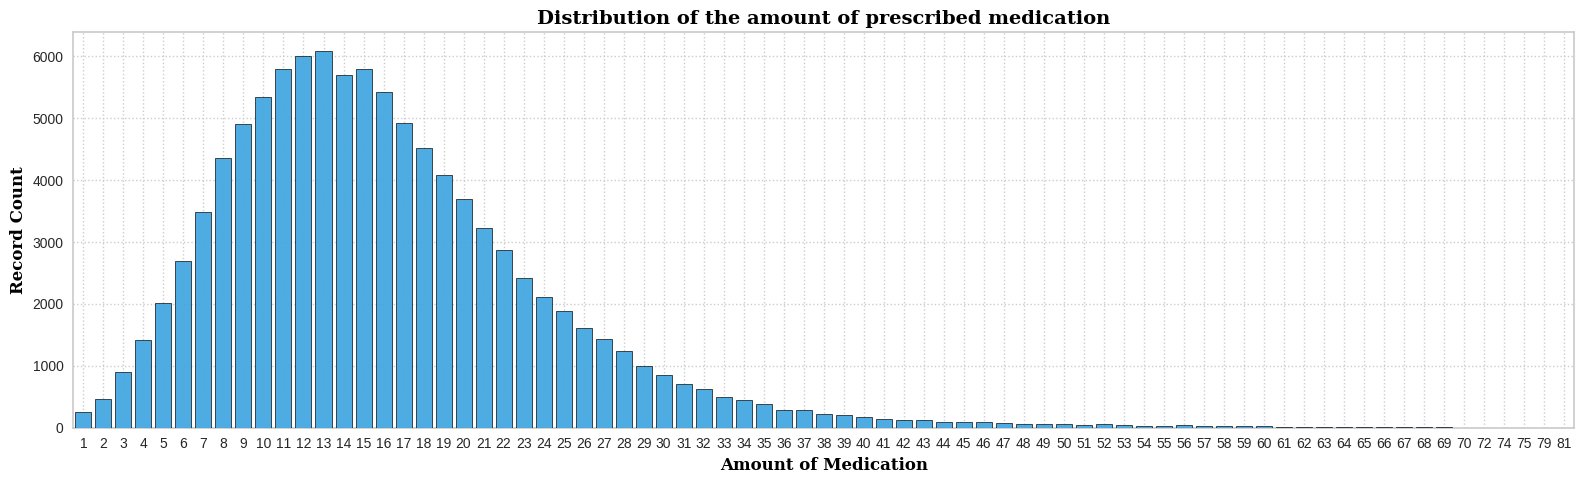

In [ ]:
plt.figure(figsize = (16,5))
sns.countplot(x = 'num_medications',data = df, color = '#2aaffb', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Amount of Medication', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Distribution of the amount of prescribed medication', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.tight_layout()

<br>

### Diagnostic Analysis

<Axes: >

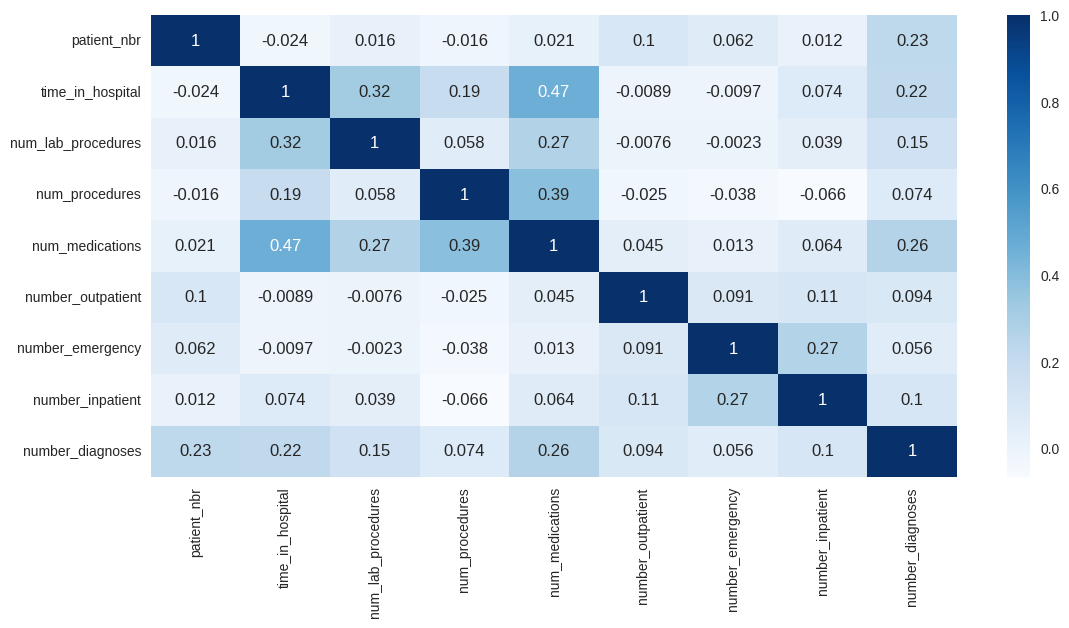

In [ ]:
# Removing the ID columns
df_corr_matrix = df.drop(columns=['encounter_id', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

plt.figure(figsize=(13,6))
sns.heatmap(df_corr_matrix.corr(),annot=True, cmap='Blues')

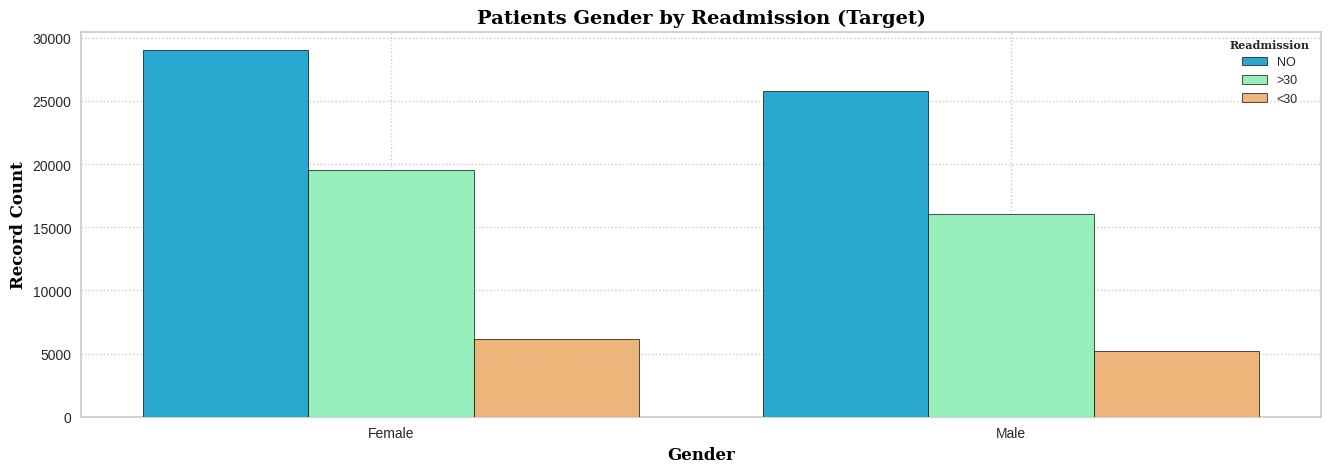

In [ ]:
hue_order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.countplot(x = 'gender',hue='readmitted', hue_order = hue_order,data = df, palette = 'rainbow', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Gender', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Patients Gender by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})

L = plt.legend(
    loc="upper right",
    fontsize=9,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1, 1.01),
)
L.set_title(
    "Readmission",
    prop={"size": 8, "family": "serif", "weight": "bold"},
)

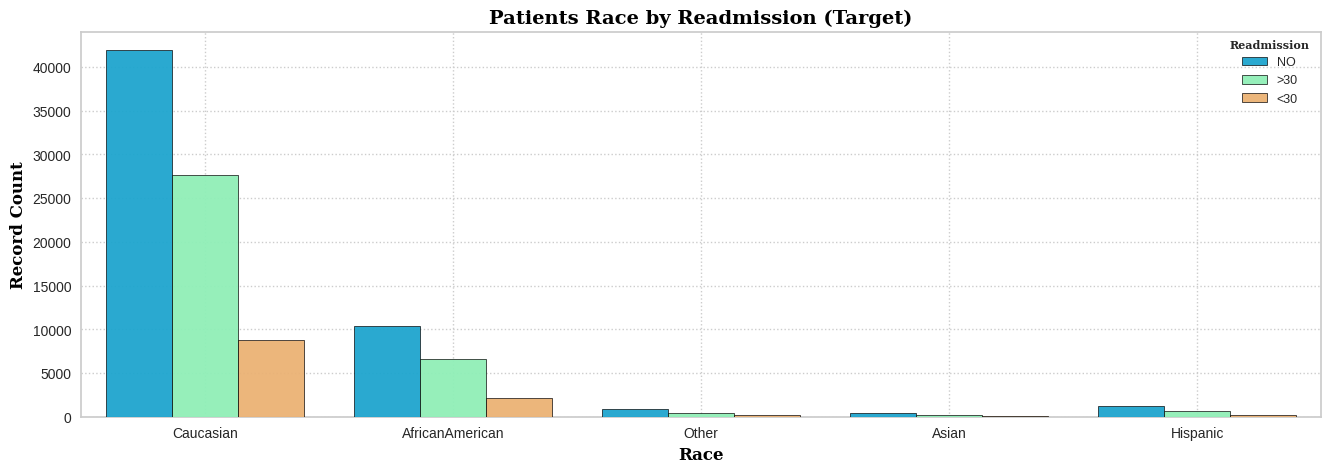

In [ ]:
hue_order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.countplot(x = 'race',hue='readmitted', hue_order = hue_order,data = df, palette = 'rainbow', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Race', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Patients Race by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})

L = plt.legend(
    loc="upper right",
    fontsize=9,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1, 1.01),
)
L.set_title(
    "Readmission",
    prop={"size": 8, "family": "serif", "weight": "bold"},
)

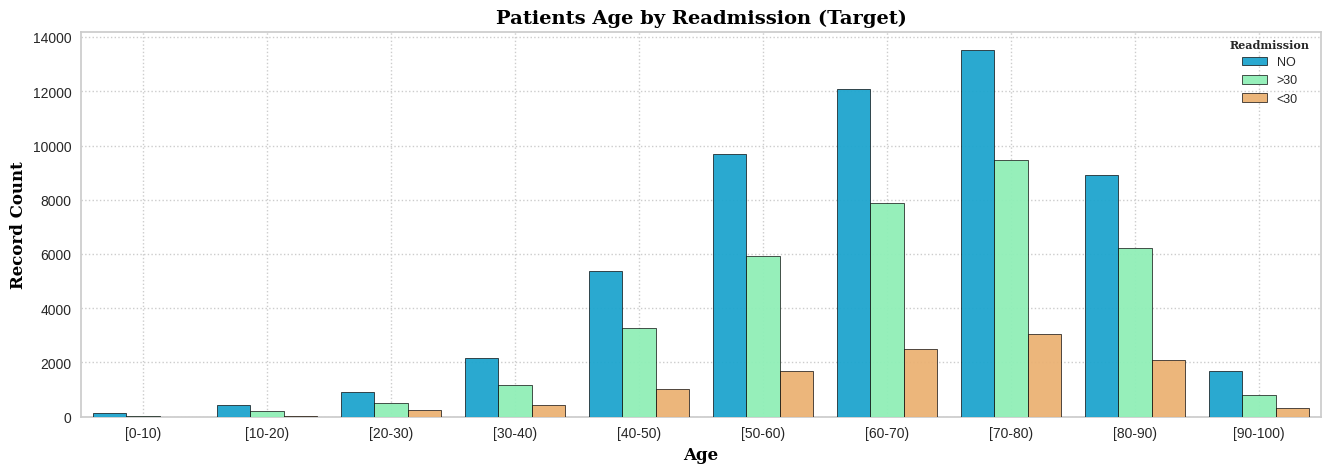

In [ ]:
hue_order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.countplot(x = 'age',hue='readmitted', hue_order = hue_order,data = df, palette = 'rainbow', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Age', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Patients Age by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})

L = plt.legend(
    loc="upper right",
    fontsize=9,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1, 1.01),
)
L.set_title(
    "Readmission",
    prop={"size": 8, "family": "serif", "weight": "bold"},
)

When we see the chart above, we can see that the ages between 70-80 have a much more weight than the others based on the range of readmissions, followed by 60-70, 50-60, 80-90, 40-50, 30-40, 90-100, 20-30 and 10-20. This insight is going to be very important when the pre-processing part arrives.

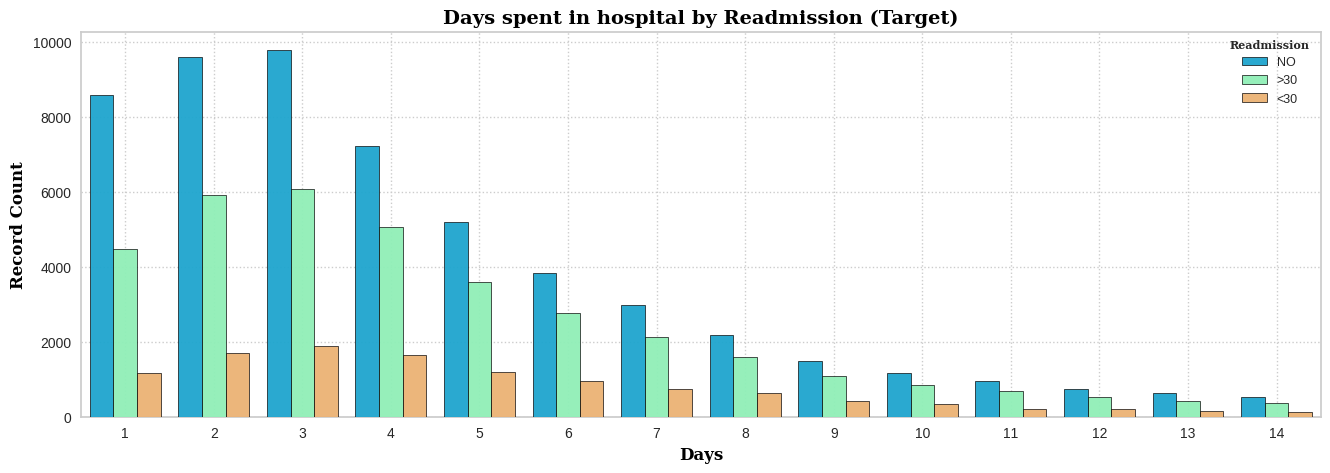

In [ ]:
hue_order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.countplot(x = 'time_in_hospital',hue='readmitted', hue_order = hue_order,data = df, palette = 'rainbow', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Days', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Days spent in hospital by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})

L = plt.legend(
    loc="upper right",
    fontsize=9,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1, 1.01),
)
L.set_title(
    "Readmission",
    prop={"size": 8, "family": "serif", "weight": "bold"},
)

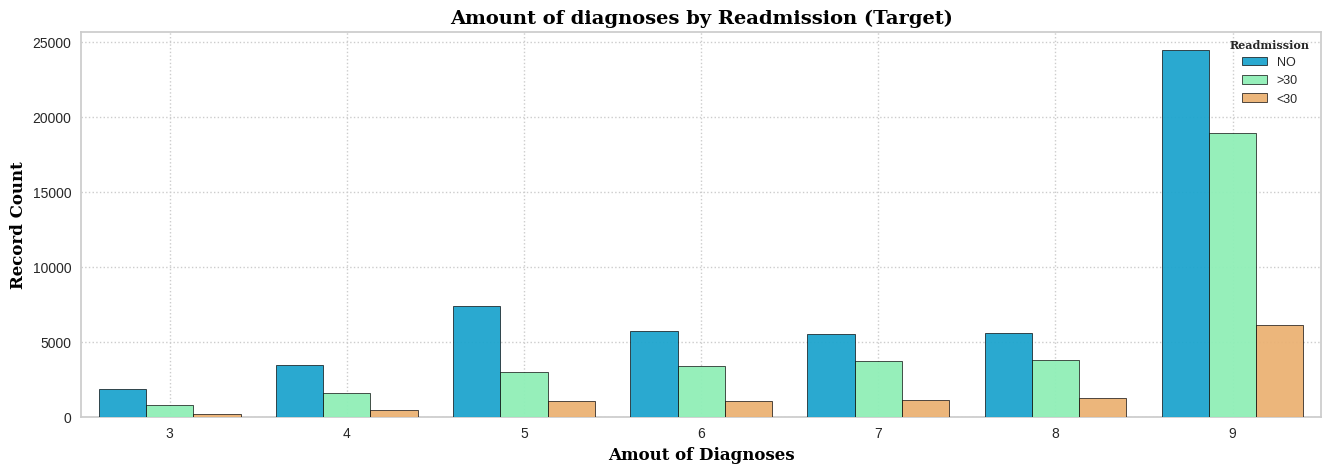

In [ ]:
order = [3, 4, 5, 6, 7, 8, 9]
hue_order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.countplot(x = 'number_diagnoses',hue='readmitted', order = order,hue_order = hue_order, data = df, palette = 'rainbow', edgecolor="black", linewidth=0.5, alpha = 0.95, zorder = 3)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.xlabel('Amout of Diagnoses', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Record Count', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.title('Amount of diagnoses by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})

L = plt.legend(
    loc="upper right",
    fontsize=9,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1, 1.01),
)
L.set_title(
    "Readmission",
    prop={"size": 8, "family": "serif", "weight": "bold"},
)

Text(0, 0.5, 'Number of Days')

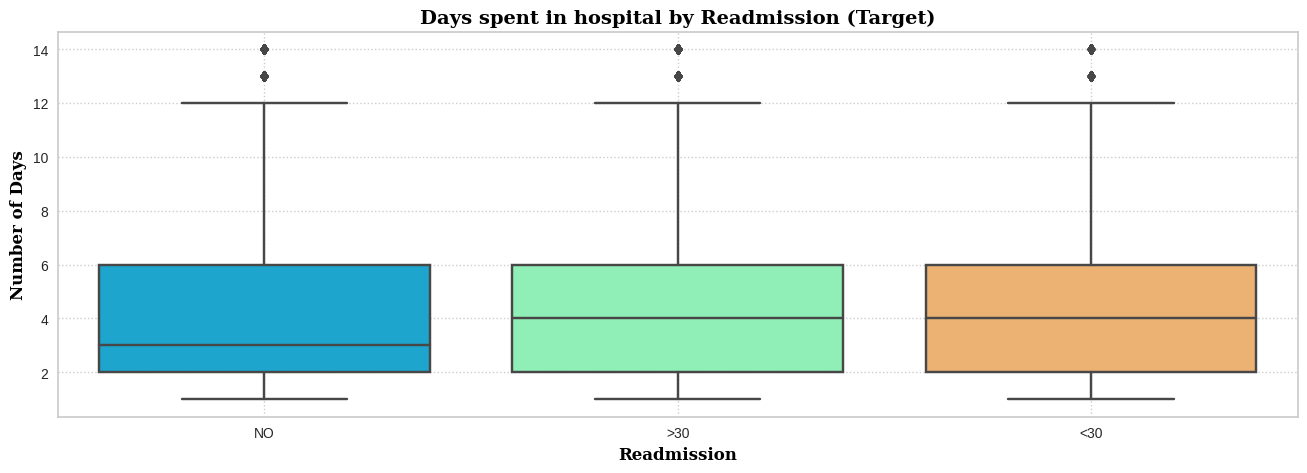

In [ ]:
order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.boxplot(x = 'readmitted', y='time_in_hospital', order=order,data = df, palette = 'rainbow')

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.title('Days spent in hospital by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.xlabel('Readmission', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Number of Days', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})

Text(0, 0.5, 'Number of Medications')

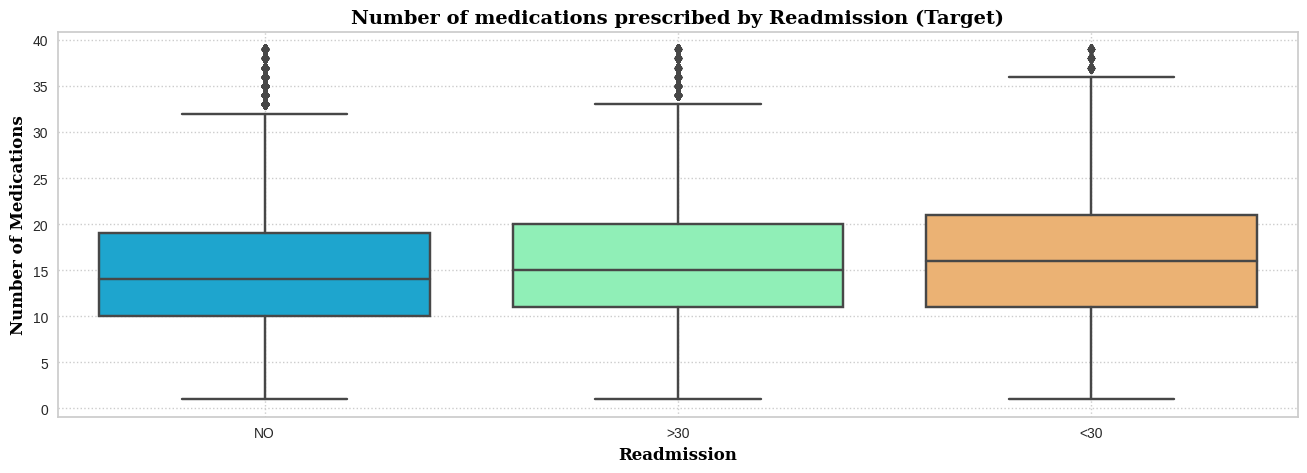

In [ ]:
order = ['NO', '>30', '<30']

df_num_days_filtered = df[df['num_medications'] < 40]

plt.figure(figsize = (16,5))
sns.boxplot(x = 'readmitted', y='num_medications', order=order,data = df_num_days_filtered, palette = 'rainbow')

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.title('Number of medications prescribed by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.xlabel('Readmission', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Number of Medications', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})

Text(0, 0.5, 'Number of lab procedures')

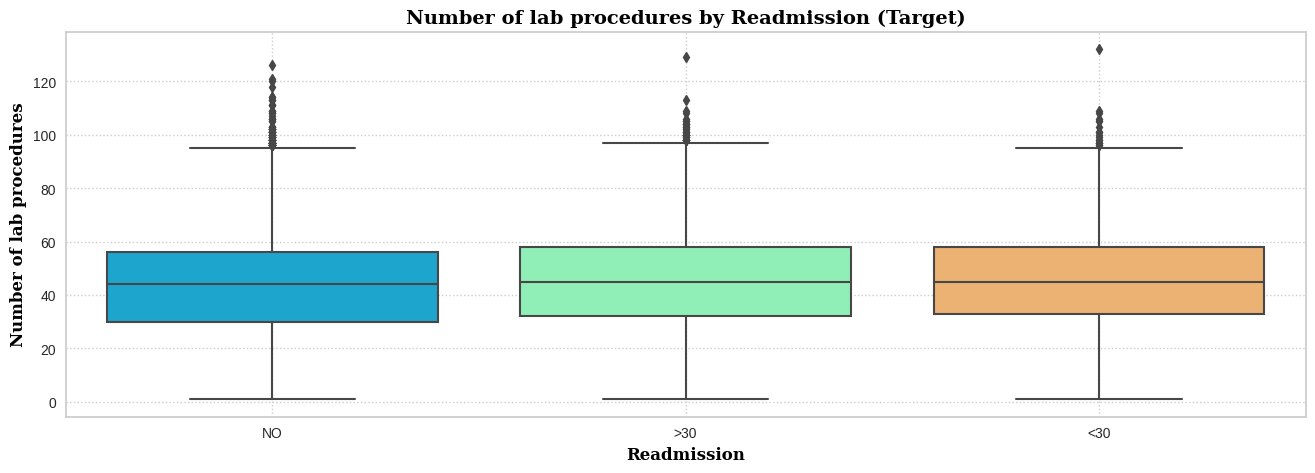

In [ ]:
order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.boxplot(x = 'readmitted', y='num_lab_procedures', order=order,data = df, palette = 'rainbow',linewidth=1.5)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.title('Number of lab procedures by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.xlabel('Readmission', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Number of lab procedures', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})

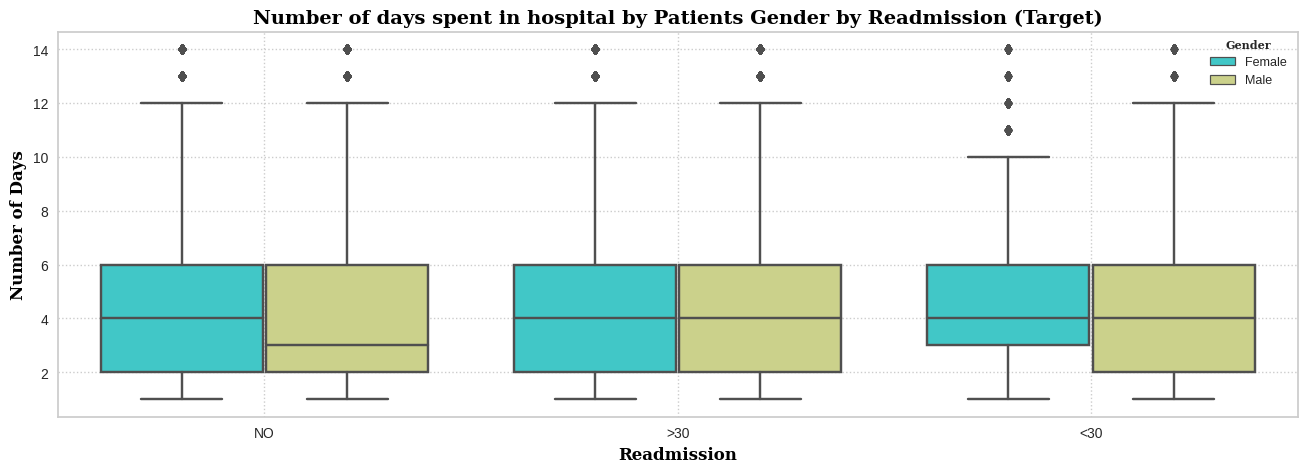

In [ ]:
order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.boxplot(x = 'readmitted', y='time_in_hospital', hue='gender',order=order,data = df, palette = 'rainbow')

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.title('Number of days spent in hospital by Patients Gender by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.xlabel('Readmission', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Number of Days', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})

L = plt.legend(
    loc="upper right",
    fontsize=9,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1, 1.01),
)
L.set_title(
    "Gender",
    prop={"size": 8, "family": "serif", "weight": "bold"},
)

Text(0, 0.5, 'Number of Diagnoses')

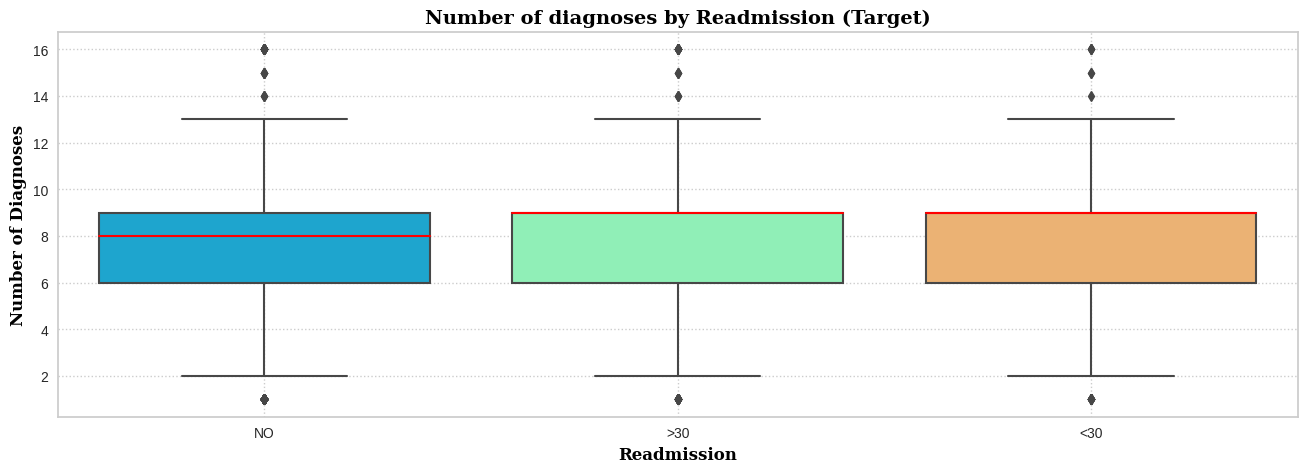

In [ ]:
order = ['NO', '>30', '<30']

plt.figure(figsize = (16,5))
sns.boxplot(x = 'readmitted', y='number_diagnoses', order=order,data = df, palette = 'rainbow',linewidth=1.5,medianprops={"color": "red"},)

plt.grid(True, zorder = 0, linestyle='dotted')
plt.rc('axes', axisbelow=True)

plt.title('Number of diagnoses by Readmission (Target)', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 14})
plt.xlabel('Readmission', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})
plt.ylabel('Number of Diagnoses', fontdict={'family': 'serif','color' : 'black','weight': 'bold','size': 12})

<br>

## **Pre-processing the Dataframe columns**
<br>

#### Starting with the ID columns

In [ ]:
# Dropping Unique ID columns for the model
df.drop(columns=['encounter_id',
                 'admission_type_id',
                 'discharge_disposition_id',
                 'admission_source_id'], inplace=True)

#### Using Label Encoder to the features that have only 2 classes and the Target

In [ ]:
#Gender, Change, DiabetesMed & readmitted (target)

le = preprocessing.LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['change'] = le.fit_transform(df['change'])
df['diabetesMed'] = le.fit_transform(df['diabetesMed'])
df['readmitted'] = le.fit_transform(df['readmitted'])

In [ ]:
df[['gender', 'change', 'diabetesMed', 'readmitted']].head()

,gender,change,diabetesMed,readmitted
0,0,1,0,2
1,0,0,1,1
2,0,1,1,2
3,1,0,1,2
4,1,0,1,2


#### Treating the age column

In [ ]:
# Order of importance: 70-80, 60-70, 50-60, 80-90, 40-50, 30-40, 90-100, 20-30, 10-20 & 0-10
ages_dict = {"[70-80)":9,
             "[60-70)":8,
             "[50-60)":7,
             "[80-90)":6,
             "[40-50)":5,
             "[30-40)":4,
             "[90-100)":3,
             "[20-30)":2,
             "[10-20)":1,
             "[0-10)":0}


df['new_age'] = df['age'].map(ages_dict)

In [ ]:
df['new_age'].value_counts().to_frame()

,new_age
9,26066
8,22482
7,17256
6,17197
5,9685
4,3775
3,2793
2,1657
1,691
0,161


In [ ]:
df['age'].value_counts().to_frame()

,age
[70-80),26066
[60-70),22482
[50-60),17256
[80-90),17197
[40-50),9685
[30-40),3775
[90-100),2793
[20-30),1657
[10-20),691
[0-10),161


In [ ]:
# dropping old age column
df.drop(columns = ['age'], inplace = True)

# renamning new_age column
df.rename(columns={'new_age':'age'}, inplace = True)

#### Using the Target Encoder technique to encode the columns without having to dummify them

In [ ]:
# Changing the patient_nbr column to string, to select it as a string column
df['patient_nbr'] = df['patient_nbr'].astype('object')

# Selecting the string categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
list(cat_cols)

['patient_nbr',
 'race',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

In [ ]:
# Applying the Target Encoding on the categorical columns
encoder = ce.TargetEncoder(cols=cat_cols)

# Indicating the target column to help the encoding to mantain the pattern of the values
df_encoded = encoder.fit_transform(df[cat_cols], df['readmitted'])

# Dropping the old string categorical columns
df.drop(columns=cat_cols, inplace=True)

# Concatenating the new encoded categorical columns to the main dataframe
df = pd.concat([df, df_encoded], axis = 1)

#### Separating the dataframe into Train & Test

In [ ]:
# Splitting the dataset
X = df.drop('readmitted',axis=1)
y = df['readmitted']

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                              test_size=0.3,random_state=111)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((71234, 42), (30529, 42), (71234,), (30529,))

#### Scaling the features with Min Max Scaler

In [ ]:
# Applying the scaling into a variable
scaler = MinMaxScaler()

# Selecting only the columns that I haven't used the target encoding above
X_normalized = scaler.fit_transform(X)

<br>

## **Feature Selection**
<br>

#### Feature Selection with Qui-Square

In [ ]:
# Select the top 'k' features using the Qui-Square technique
k = 25  # Number of features to be selected
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X_normalized, y)

# getting the index of the selected features
selected_indexes_quisquare = selector.get_support(indices=True)

# Print the selected features
selected_indexes_quisquare = X.columns[selected_indexes_quisquare]
selected_indexes_quisquare = list(selected_indexes_quisquare)

# The list is ordered by the feature importance selected by the Qui-Square Technique, basically the more important feature is the 'gender', 'time_in_hospital', 'num_lab_procedures' and so on.,

#### Feature Selection with Correlation Matrix

<Axes: >

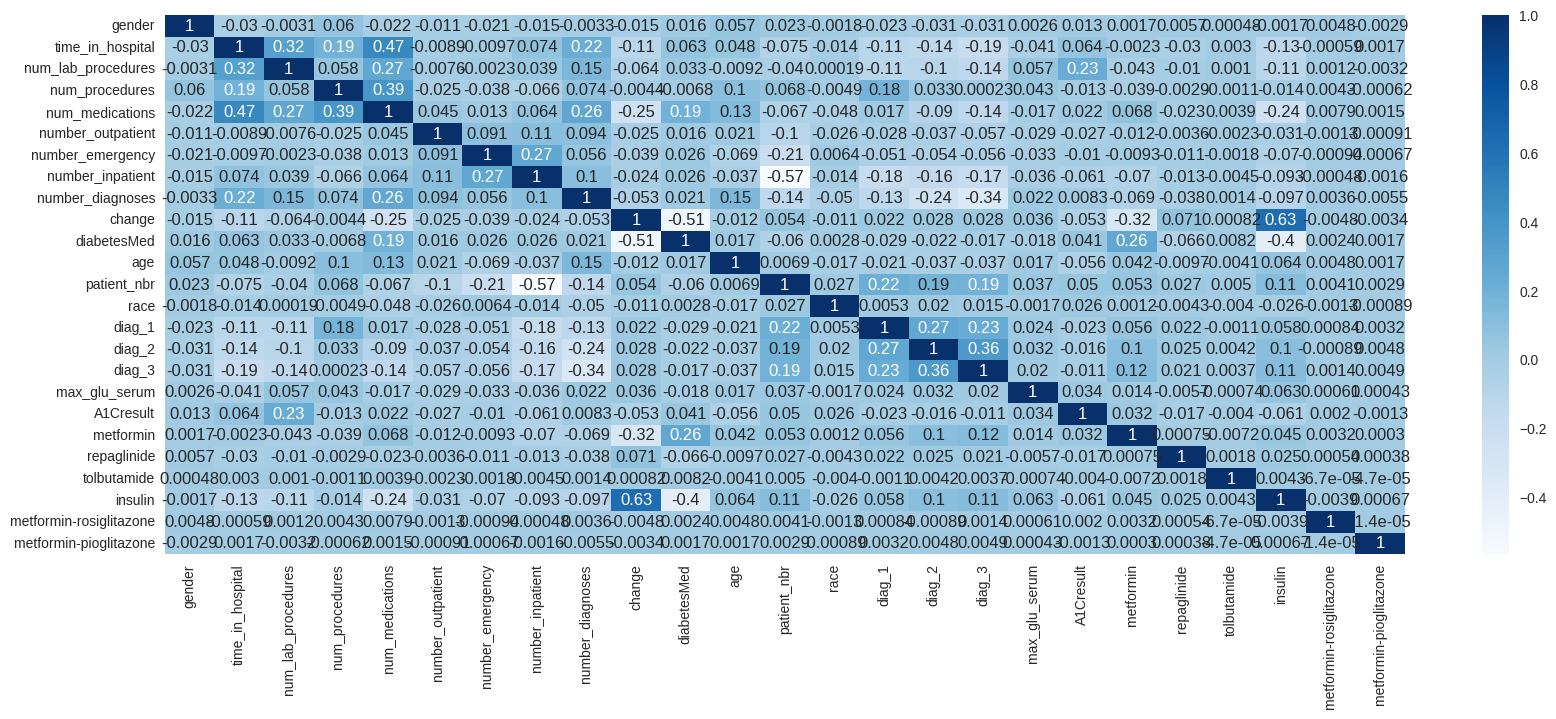

In [ ]:
plt.figure(figsize=(20,7))
# Understanding better the correlation between the selected features by Qui-Square
sns.heatmap(df[selected_indexes_quisquare].corr(),annot=True, cmap='Blues')

<br>

## **Predictive Modeling**
<br>

In [ ]:
# Setting up the final train and test dataframes on the PyCaret's auto-ml library
exp_name = setup(data = X[selected_indexes_quisquare],  target=y, session_id = 2849)

# Making the comparasion of the models
best_model = compare_models()

,Description,Value
0,Session id,2849
1,Target,readmitted
2,Target type,Multiclass
3,Original data shape,"(101763, 26)"
4,Transformed data shape,"(101763, 26)"
5,Transformed train set shape,"(71234, 26)"
6,Transformed test set shape,"(30529, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8575,0.9665,0.8575,0.8614,0.8568,0.7520,0.7546,3.0840
xgboost,Extreme Gradient Boosting,0.8551,0.9655,0.8551,0.8580,0.8543,0.7476,0.7498,35.5130
catboost,CatBoost Classifier,0.8551,0.9659,0.8551,0.8580,0.8544,0.7477,0.7498,53.3520
gbc,Gradient Boosting Classifier,0.8520,0.9642,0.8520,0.8586,0.8494,0.7413,0.7465,41.6950
rf,Random Forest Classifier,0.8448,0.9597,0.8448,0.8565,0.8433,0.7305,0.7381,11.3100
et,Extra Trees Classifier,0.8356,0.9523,0.8356,0.8493,0.8322,0.7135,0.7231,14.5510
ada,Ada Boost Classifier,0.8132,0.9257,0.8132,0.8316,0.8140,0.6781,0.6875,4.0630
dt,Decision Tree Classifier,0.8084,0.8469,0.8084,0.8086,0.8085,0.6669,0.6669,0.7080
lr,Logistic Regression,0.7970,0.9325,0.7970,0.7960,0.7883,0.6358,0.6392,16.1870
lda,Linear Discriminant Analysis,0.7928,0.9323,0.7928,0.7872,0.7868,0.6299,0.6316,0.4790


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
best_model # here is the best model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2849, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [84]:
lgbm = tune_model(best_model) # This is the pycaret tunning with a cross-validation evaluating the prediction on 10 different folds

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:37:25
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8530,0.9638,0.8530,0.8579,0.8530,0.7448,0.7474
1,0.8623,0.9676,0.8623,0.8652,0.8617,0.7602,0.7622
2,0.8554,0.9666,0.8554,0.8588,0.8545,0.7482,0.7507
3,0.8612,0.9664,0.8612,0.8651,0.8603,0.7582,0.7609
4,0.8596,0.9675,0.8596,0.8634,0.8592,0.7561,0.7585
5,0.8564,0.9660,0.8564,0.8601,0.8555,0.7500,0.7526
6,0.8588,0.9677,0.8588,0.8618,0.8577,0.7538,0.7561
7,0.8596,0.9677,0.8596,0.8626,0.8587,0.7552,0.7574
8,0.8546,0.9650,0.8546,0.8582,0.8536,0.7467,0.7493


In [85]:
lgbm # Best parameters

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2849, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<br>

## **Model Evaluation**
<br>

In [86]:
predictions = predict_model(lgbm)
y_true = predictions['readmitted']
y_pred = predictions['prediction_label']

print(classification_report(y_true, y_pred))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8609,0.9672,0.8609,0.8652,0.8604,0.7581,0.7607


              precision    recall  f1-score   support

           0       0.71      0.56      0.63      3407
           1       0.77      0.88      0.82     10664
           2       0.96      0.91      0.94     16458

    accuracy                           0.86     30529
   macro avg       0.81      0.78      0.79     30529
weighted avg       0.87      0.86      0.86     30529



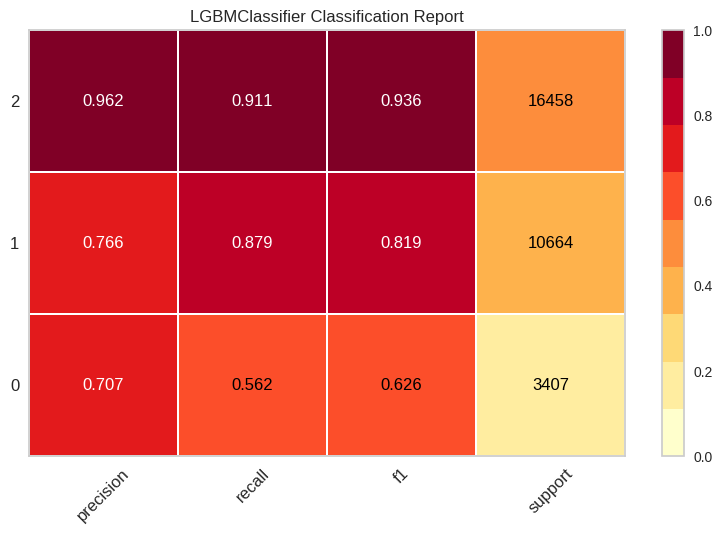

In [87]:
plot_model(lgbm, plot = 'class_report')

<br>

## **Very Quick Prescriptive Analysis**
<br>

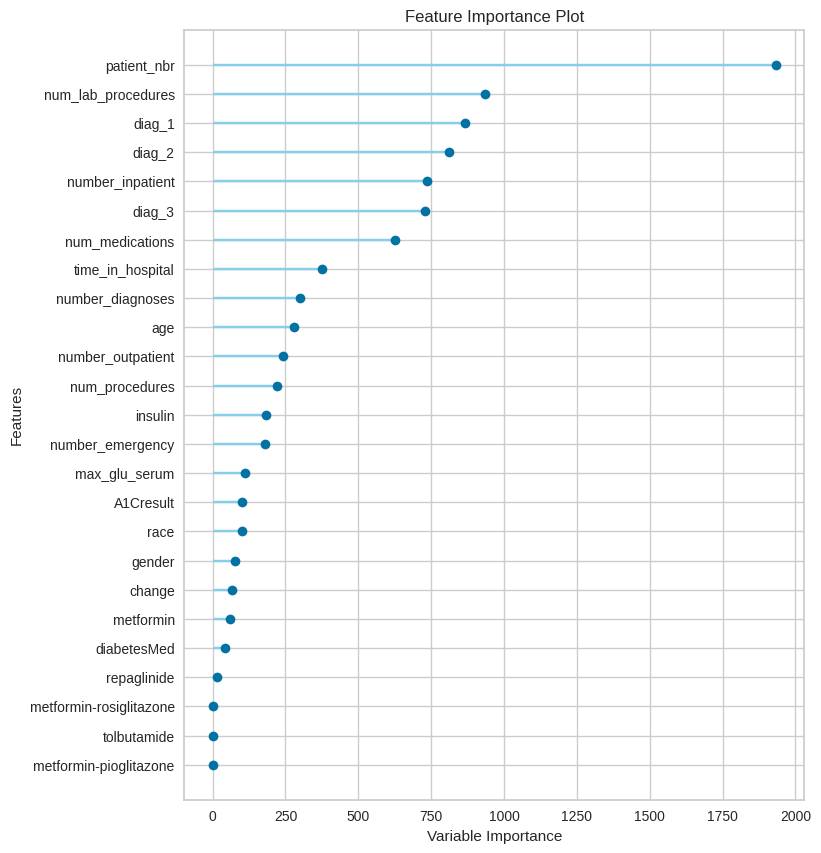

In [88]:
plot_model(lgbm, plot = 'feature_all')

<br>

## **Saving and Loading Model**
<br>

In [89]:
# save model
final_model = finalize_model(lgbm)
save_model(final_model, 'diabetic_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['gender', 'time_in_hospital',
                                              'num_lab_procedures',
                                              'num_procedures',
                                              'num_medications',
                                              'number_outpatient',
                                              'number_emergency',
                                              'number_inpatient',
                                              'number_diagnoses', 'change',
                                              'diabetesMed', 'age',
                                              'patient_nbr', 'race', 'diag_1',
                                              'diag_2', 'di...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                           

In [90]:
# load model
saved_model = load_model('diabetic_model')

Transformation Pipeline and Model Successfully Loaded


In [91]:
# printing the loaded model
print(saved_model)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['gender', 'time_in_hospital',
                                             'num_lab_procedures',
                                             'num_procedures',
                                             'num_medications',
                                             'number_outpatient',
                                             'number_emergency',
                                             'number_inpatient',
                                             'number_diagnoses', 'change',
                                             'diabetesMed', 'age',
                                             'patient_nbr', 'race', 'diag_1',
                                             'diag_2', 'di...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_

<br>
<br>
<hr>